# Lab 8. Image processing
#### Computational Methods for Geoscience - Fall 2023
#### Instructor: Eric Lindsey

Due: Oct. 31, 2023

---------

In [2]:
# Install OpenCV
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 22.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
import scipy.fft
import scipy.signal
import cv2

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens
# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2

# not used in this lab:

#import netCDF4 as nc
#import datetime
#import scipy.optimize
#import time
#import multiprocessing as mp

### Assignment 1. Re-order the bands of an image and display it
a. Read in the landsat data from 10/16/2023 over Albuquerque, and plot the bands separately.

The bands represent the following information:
- Band 2: Blue
- Band 3: Green
- Band 4: Red
- Band 5: Near-infrared

b. Create an "RGB" composite to view the image in true color. Set the bounds of your plot to view just the area around Albuquerque and the Sandias.

c. Then try computing NDVI using the Red and Near-infrared bands and plot that image.


### Assignment 2. Filtering the image

Apply the following filters to the grayscale image of my cat Pumpkin, and plot them all together with the original

- 9x9 smoothing
- 9x9 median
- Edge detection

For the last one, use the function 'cv2.canny', which is a common edge detection filter. You'll have to look up how to use it!


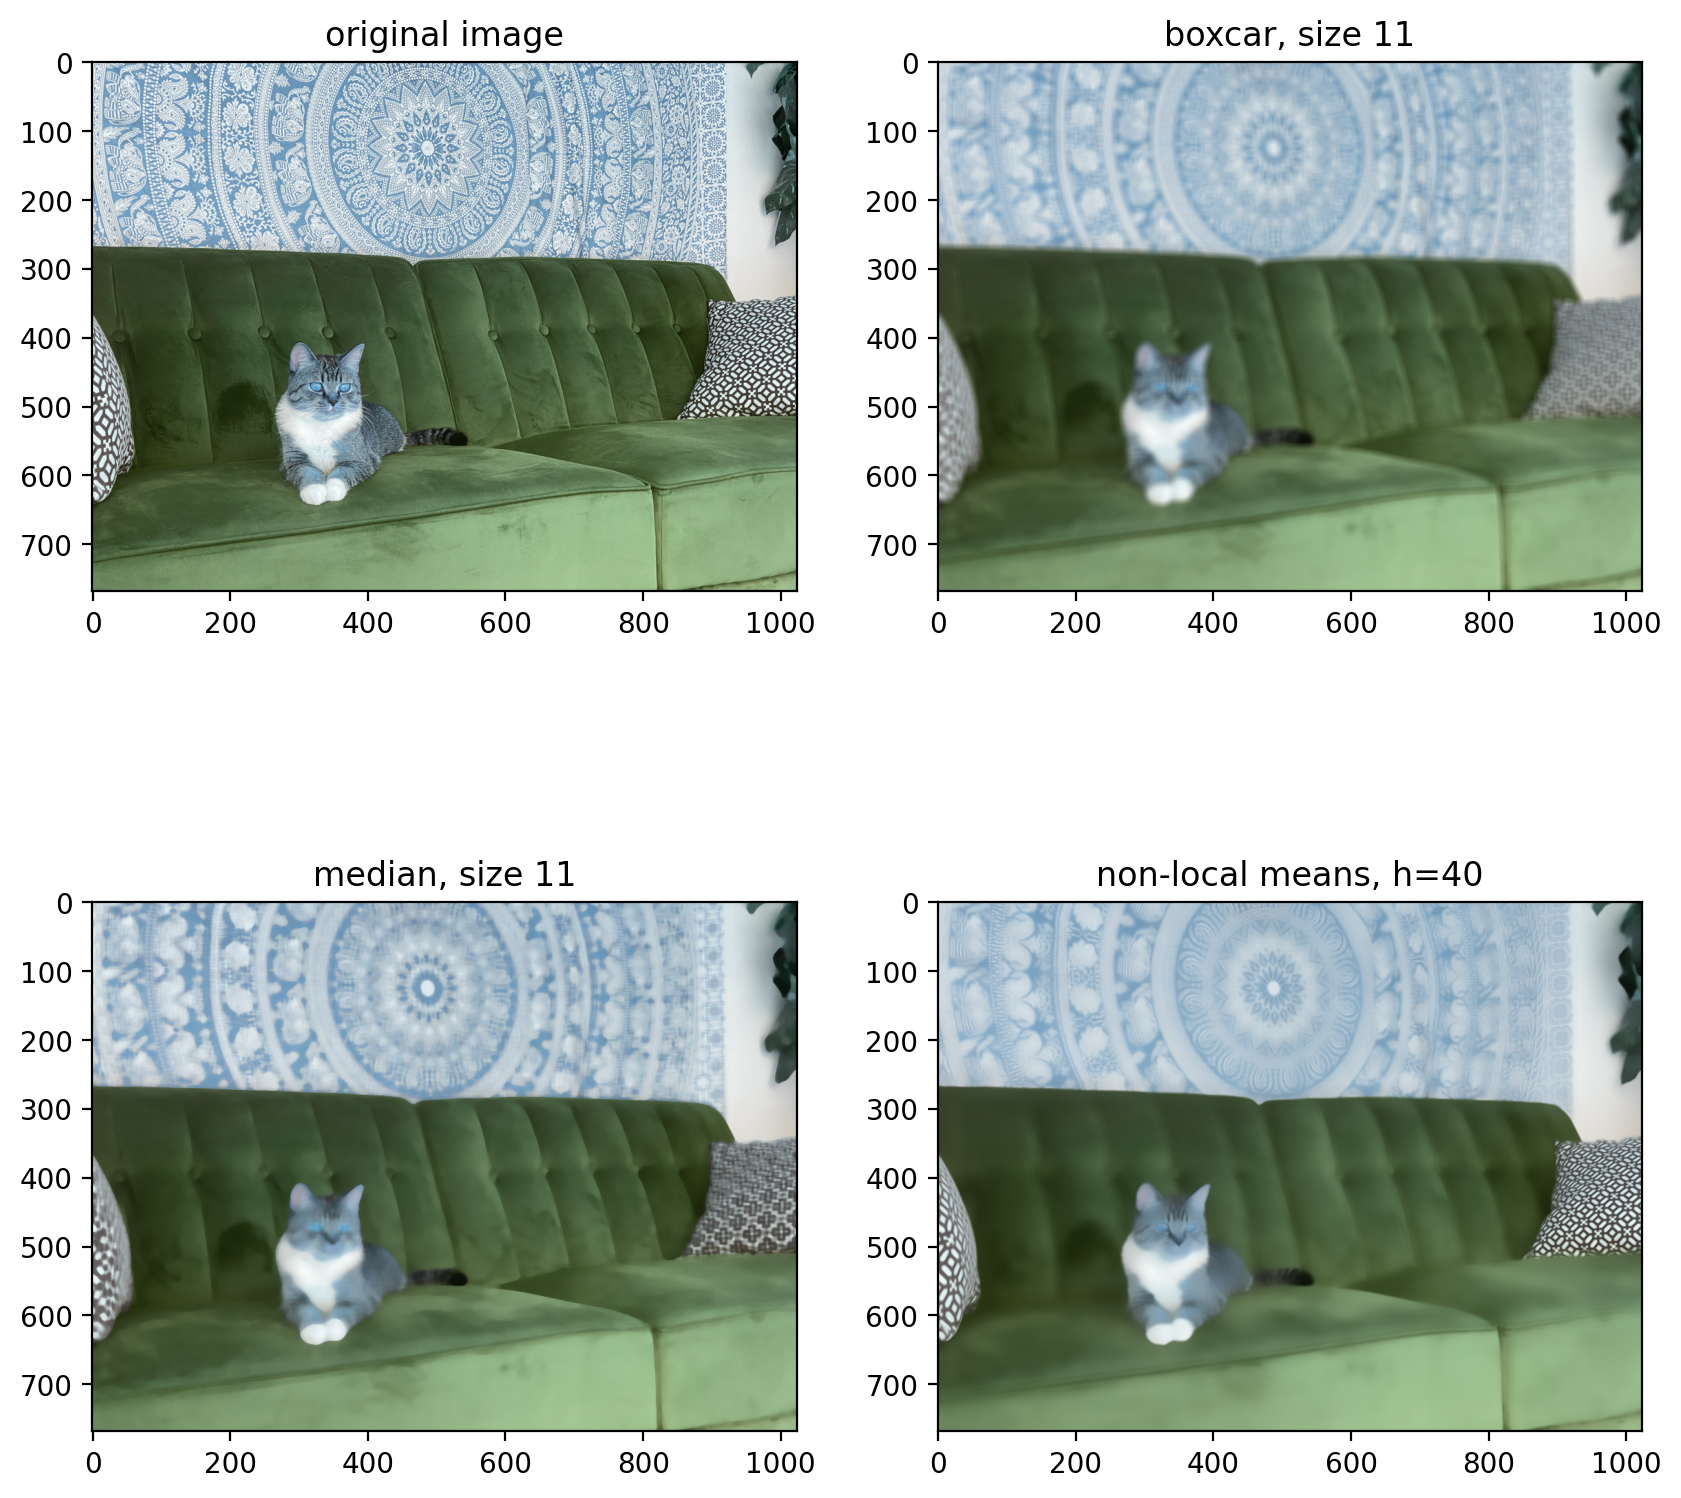

In [15]:
cat = cv2.imread('pumpkin.jpg')

fig,axs=plt.subplots(2,2,figsize=(10,10))

# this SAR image is pretty speckled.
axs[0,0].imshow(cat,cmap='gray')
axs[0,0].set_title('original image')

# let's try to filter it with a 9x9 boxcar filter. This can be done easily with cv2.blur(img,(xsize,ysize))
img_blur = cv2.blur(cat,(11,11))
axs[0,1].imshow(img_blur,cmap='gray')
axs[0,1].set_title('boxcar, size 11')

# that's not great, what about a median filter?
img_median = cv2.medianBlur(cat,11)
axs[1,0].imshow(img_median,cmap='gray')
axs[1,0].set_title('median, size 11')

# OpenCV has some much more advanced options - let's try one out!
img_denoise = cv2.fastNlMeansDenoising(cat,h=40)
axs[1,1].imshow(img_denoise,cmap='gray')
axs[1,1].set_title('non-local means, h=40')
# pretty nice! Much sharper than the boxcar or median filters. Although it might be making up some texture?

plt.show()

## Image thresholding and connected components



### Assignment 3: labeling the icebergs on the figure

The information output by the connected components identifier contains other useful information besides just the shape areas. For example, we can get the object centroids within our for loop, with 

    (cx, cy) = centroids[i]
    
and bounding-box information with

    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]

Copy the code above and modify it to plot the original grayscale image, but with a red text label on the figure at the centroid location of each iceberg displaying that iceberg's area if it's larger than your chosen threshold, and draw a bounding box around the largest one.

identified 2176 icebergs
7 are larger than the min size of 1000


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

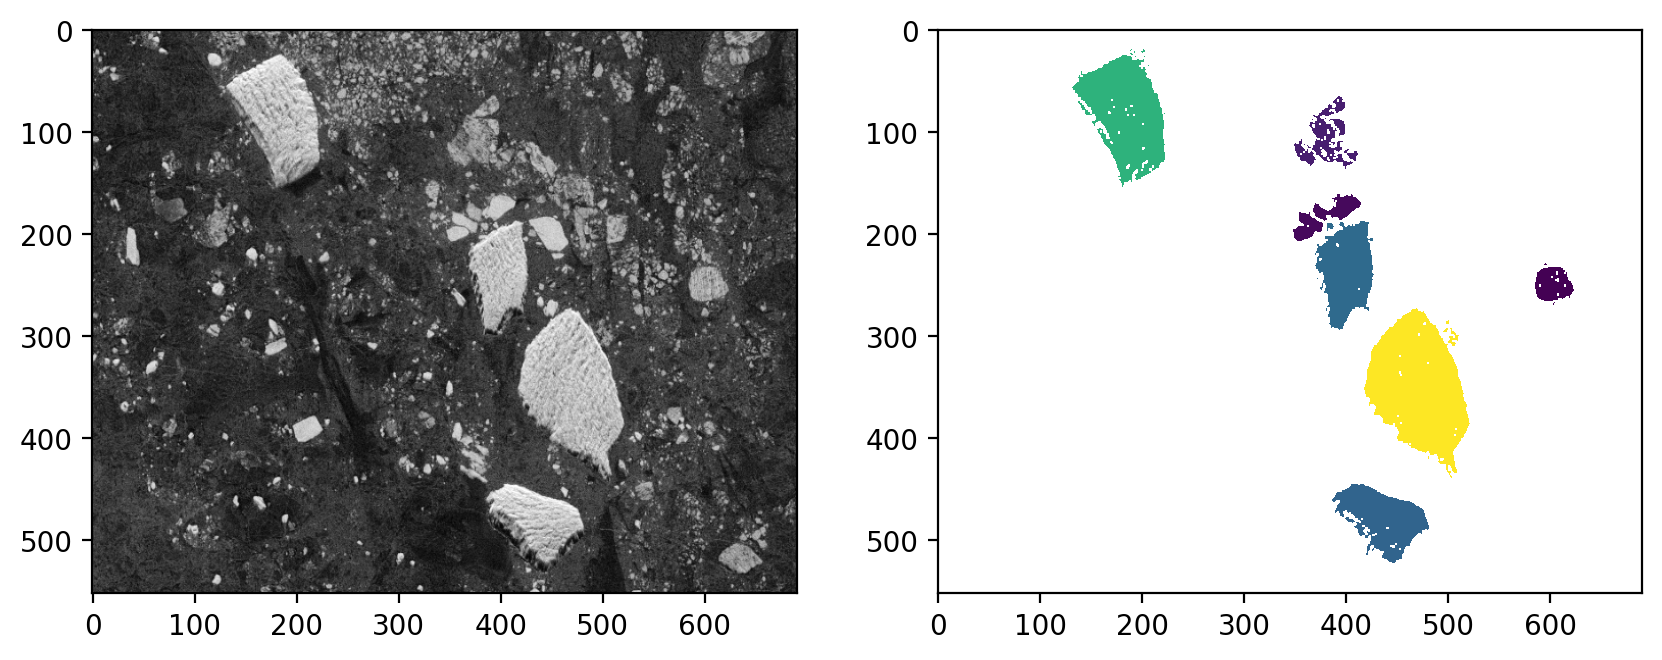

In [32]:
# load the (grayscale) image and make a plot
img = cv2.imread('iceye_icebergs.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img_gray,cmap='gray')

# now apply the segmentation
# based (in part) on a long tutorial here: 
# https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

# this value defines what is "connected" - it is either 4 (edges only) or 8 (diagonals OK)
connectivity = 4 

# get the connected components:
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity, cv2.CV_32S)

# how many did we find?
print('identified', numLabels, 'icebergs')

# loop over the components, and if their areas are above the required size, add them to the map.
minArea = 1000
mask=np.zeros(np.shape(img_binary))
count=0
for i in range(numLabels):
    area = stats[i,cv2.CC_STAT_AREA]
    # note, we skip label 1 because this is the largest - usually the background of the image!
    if i>0 and area > minArea:
        #componentMask = (labels == i).astype("uint8") * 255
        #mask = cv2.bitwise_or(mask, componentMask)
        count += 1
        object_mask = (labels == i)
        mask[object_mask] = area
        
# make any areas that are still zero into nan, for a white background:
mask[mask==0] = np.nan

print(count, 'are larger than the min size of',minArea)

axs[1].imshow(mask)
axs[2].colorbar(label='area (pixels)')
plt.show()

# threshold the image at a grayscale value of 127 (halfway through the range).
# we also have to specify the "threshold type", which here is cv2.THRESH_BINARY
# finally, notice that there are 2 outputs of this function - the threshold value and the image.
# see a nice tutorial here: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
#thres_value, img_binary = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)
#axs[1].imshow(img_binary,cmap='gray')
#plt.show()

identified 2176 icebergs
7 are larger than the min size of 1000


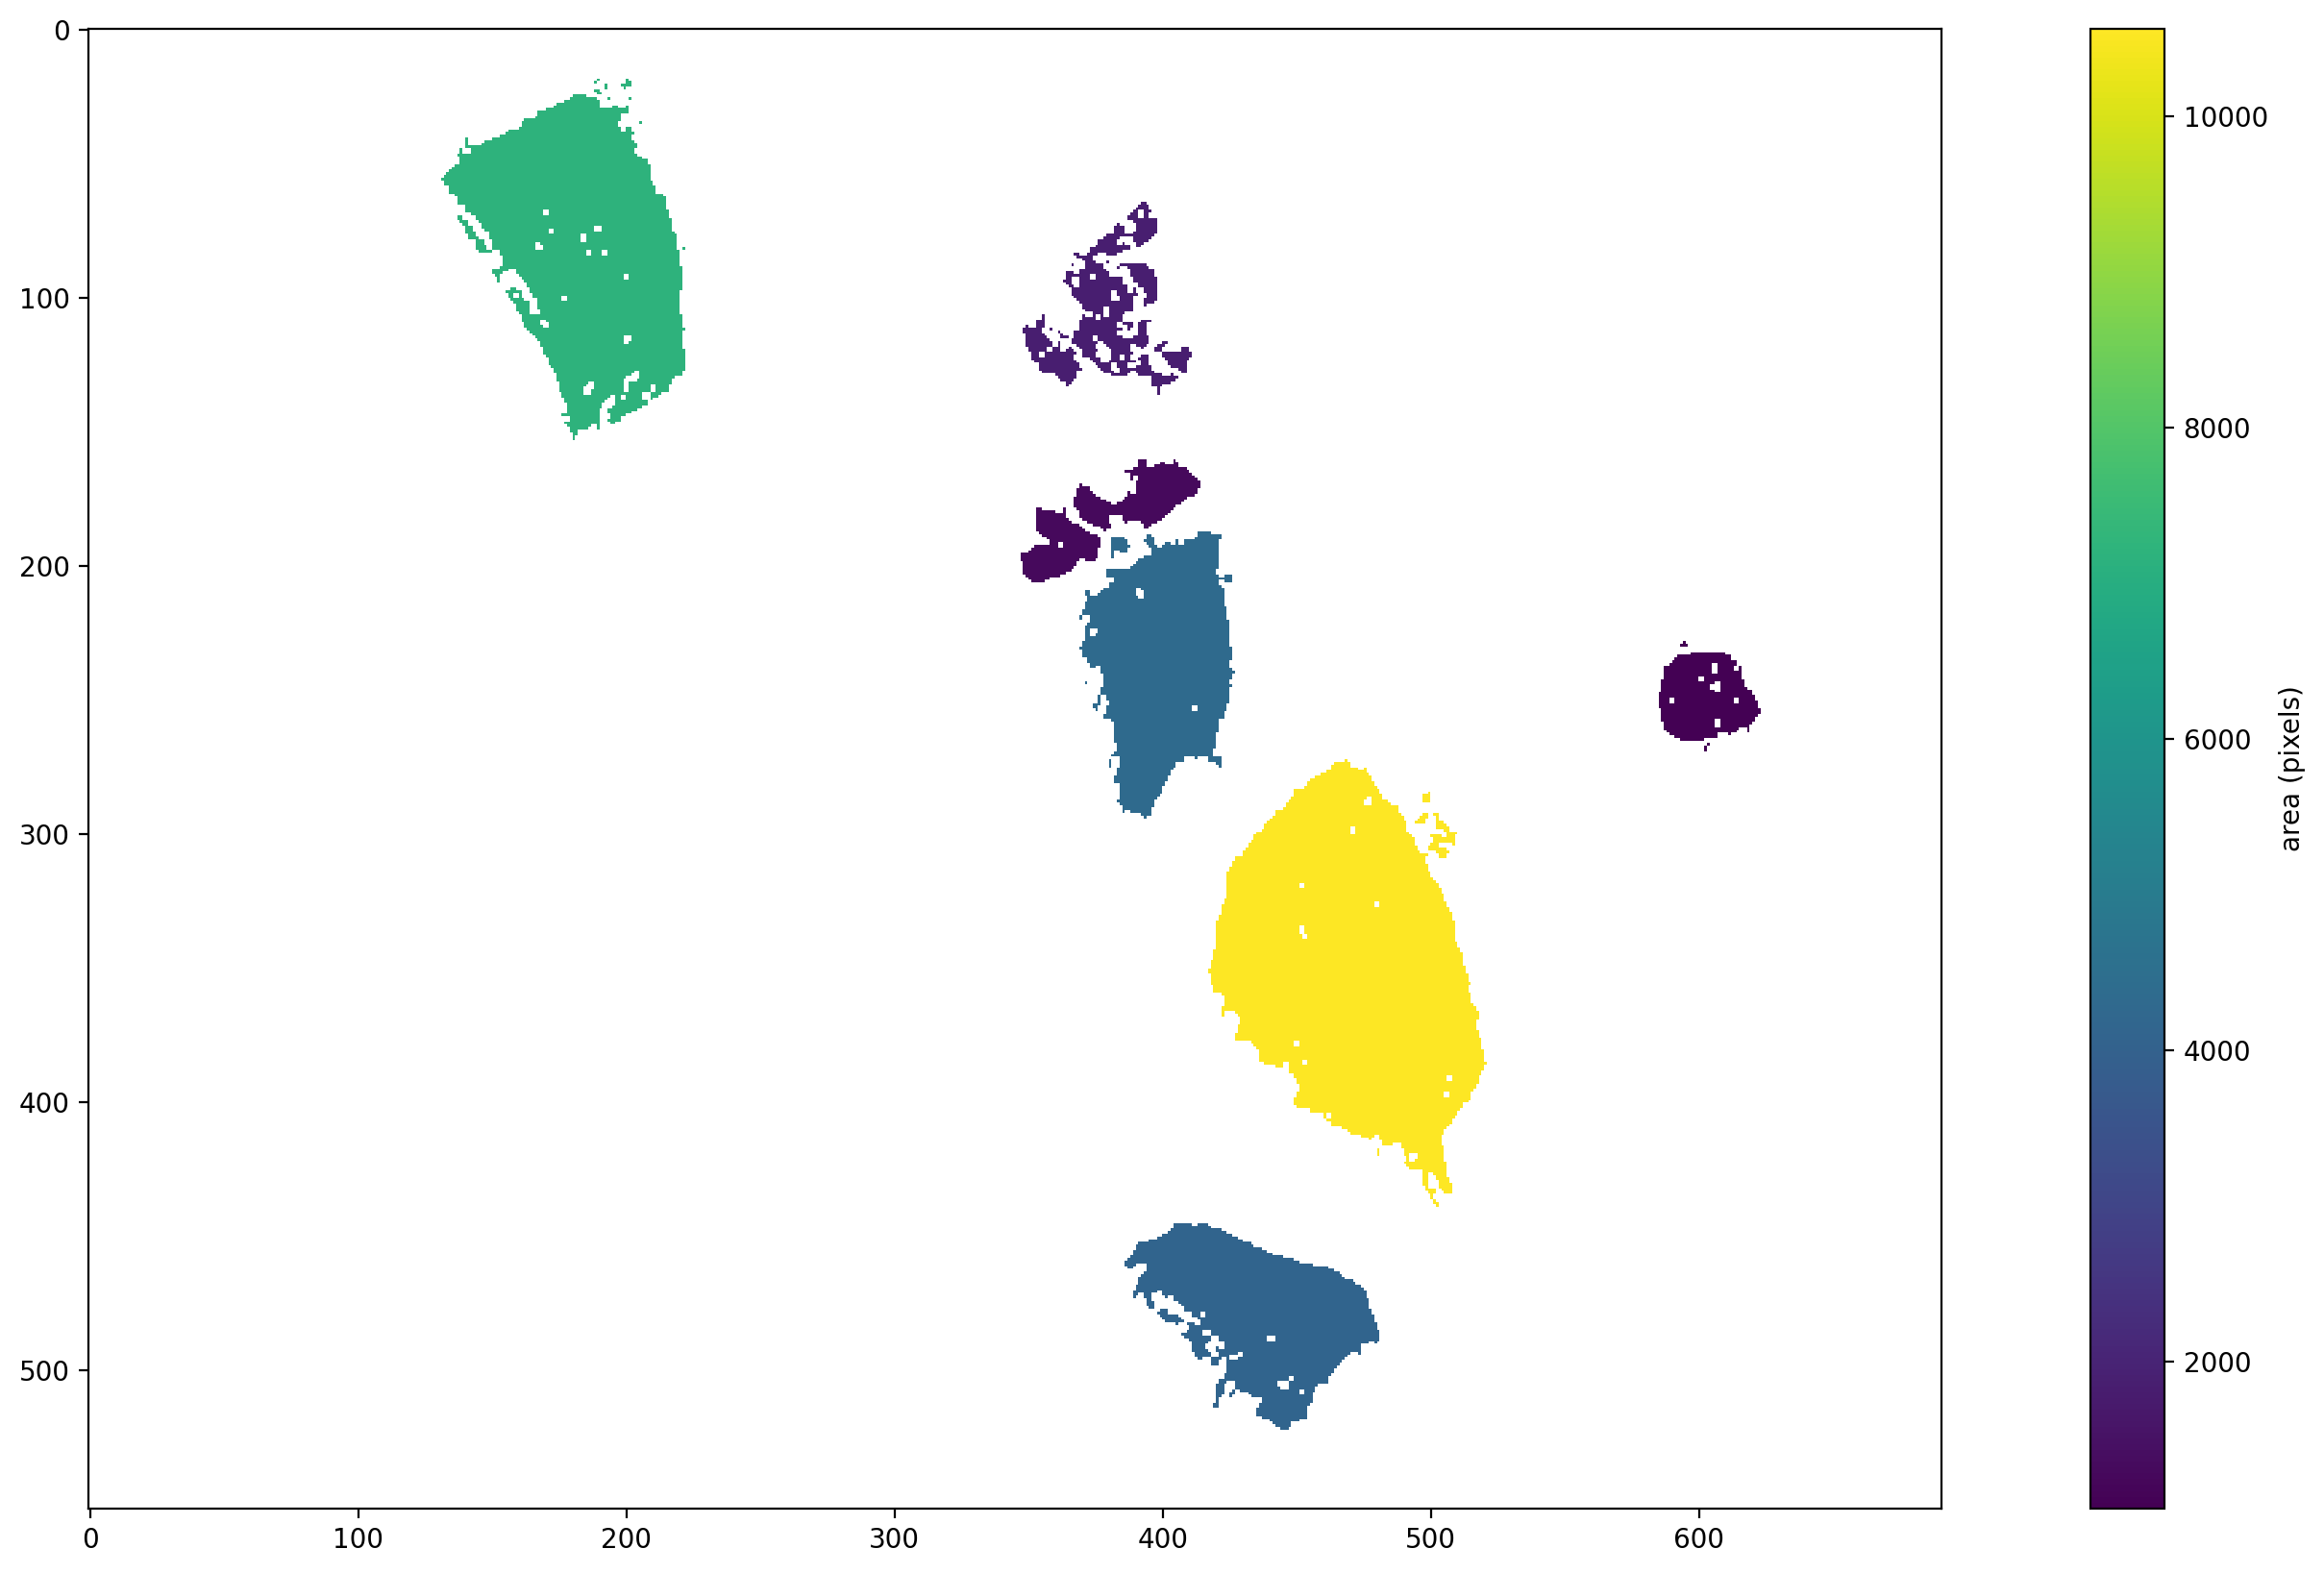

In [116]:
# now apply the segmentation
# based (in part) on a long tutorial here: 
# https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

# this value defines what is "connected" - it is either 4 (edges only) or 8 (diagonals OK)
connectivity = 4 

# get the connected components:
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity, cv2.CV_32S)

# how many did we find?
print('identified', numLabels, 'icebergs')

# loop over the components, and if their areas are above the required size, add them to the map.
minArea = 1000
mask=np.zeros(np.shape(img_binary))
count=0
for i in range(numLabels):
    area = stats[i,cv2.CC_STAT_AREA]
    # note, we skip label 1 because this is the largest - usually the background of the image!
    if i>0 and area > minArea:
        #componentMask = (labels == i).astype("uint8") * 255
        #mask = cv2.bitwise_or(mask, componentMask)
        count += 1
        object_mask = (labels == i)
        mask[object_mask] = area
        
# make any areas that are still zero into nan, for a white background:
mask[mask==0] = np.nan

print(count, 'are larger than the min size of',minArea)
plt.figure(figsize=(20,10))
plt.imshow(mask)
plt.colorbar(label='area (pixels)')
plt.show()


### Assignment 4: connected components of your own image!

Find an image you think could be easily thresholded and separated into connected components, then apply the above method to it. Be creative - for example, maybe you could use this method to identify and count balloons in the sky, or olivine crystals from a thin section, or even get the relative abundances of different minerals, if you can identify them separately using the different color bands.

Or maybe you can count penguins!